# Libraries

In [20]:
import numpy as np
import pandas as pd

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 999)

import matplotlib.pyplot as plt
import seaborn as sns

import itertools
from pathlib import Path


In [21]:
# !pip install pystan==2.19.1.1
# !pip install prophet

from prophet import Prophet

# Load the data

In [22]:
PATH = Path.cwd().parent
RAW_PATH = Path(PATH, "./data/raw/") 

In [23]:
train = pd.read_csv(Path(RAW_PATH, 'train.csv'))
train['date'] = pd.to_datetime(train.date)
print(train.info())
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26298 entries, 0 to 26297
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   row_id    26298 non-null  int64         
 1   date      26298 non-null  datetime64[ns]
 2   country   26298 non-null  object        
 3   store     26298 non-null  object        
 4   product   26298 non-null  object        
 5   num_sold  26298 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 1.2+ MB
None


,row_id,date,country,store,product,num_sold
0,0,2015-01-01,Finland,KaggleMart,Kaggle Mug,329
1,1,2015-01-01,Finland,KaggleMart,Kaggle Hat,520
2,2,2015-01-01,Finland,KaggleMart,Kaggle Sticker,146
3,3,2015-01-01,Finland,KaggleRama,Kaggle Mug,572
4,4,2015-01-01,Finland,KaggleRama,Kaggle Hat,911


In [24]:
test = pd.read_csv(Path(RAW_PATH, 'test.csv'))
test['date'] = pd.to_datetime(test.date)
print(test.info())
test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6570 entries, 0 to 6569
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   row_id   6570 non-null   int64         
 1   date     6570 non-null   datetime64[ns]
 2   country  6570 non-null   object        
 3   store    6570 non-null   object        
 4   product  6570 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 256.8+ KB
None


,row_id,date,country,store,product
0,26298,2019-01-01,Finland,KaggleMart,Kaggle Mug
1,26299,2019-01-01,Finland,KaggleMart,Kaggle Hat
2,26300,2019-01-01,Finland,KaggleMart,Kaggle Sticker
3,26301,2019-01-01,Finland,KaggleRama,Kaggle Mug
4,26302,2019-01-01,Finland,KaggleRama,Kaggle Hat


# Competition Metric
https://www.kaggle.com/cpmpml/smape-weirdness

In [25]:
def SMAPE(y_true, y_pred):
    denominator = (y_true + np.abs(y_pred)) / 200.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return np.mean(diff)

# Summary

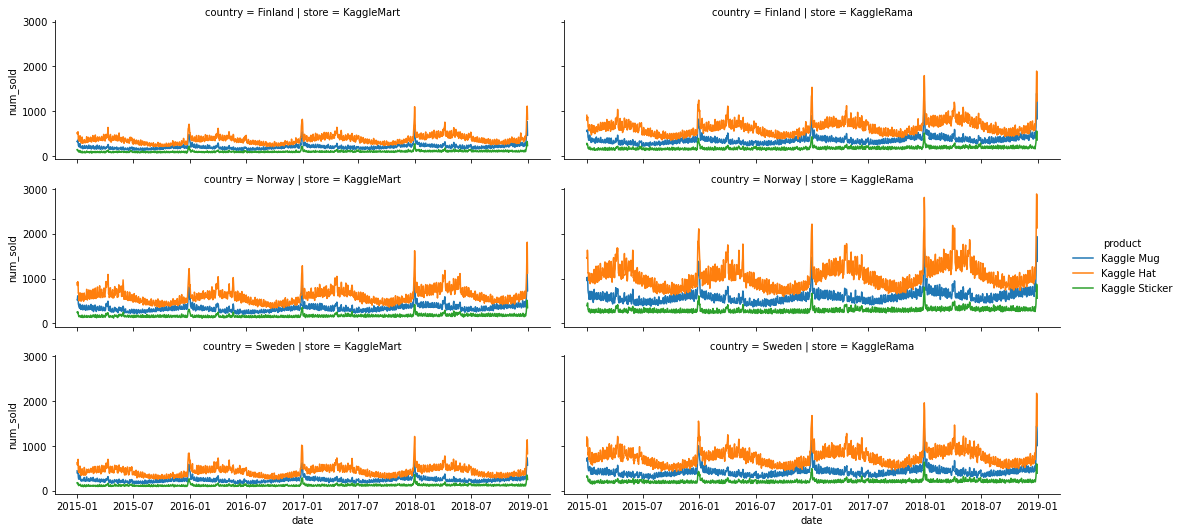

In [26]:
sns.relplot(data=train, x='date', y='num_sold', row='country', col='store', hue='product',
            aspect=3, height=2.5, kind='line')

# Train Test Val Split

In [27]:
val = train[train.date >= '2018-01-01'].copy()
val.reset_index(drop=True, inplace=True)
train = train[train.date < '2018-01-01'].copy()
train.reset_index(drop=True, inplace=True)
train.rename({'date':'ds', 'num_sold':'y'}, axis=1, inplace=True)
val.rename({'date':'ds', 'num_sold':'y'}, axis=1, inplace=True)
test.rename({'date':'ds'}, axis=1, inplace=True)

print('Train', train.shape, '| Start', train.ds.min(), '| End', train.ds.max())
print('Val', val.shape, '| Start', val.ds.min(), '| End', val.ds.max())
print('Test', test.shape, '| Start', test.ds.min(), '| End', test.ds.max())

Train (19728, 6) | Start 2015-01-01 00:00:00 | End 2017-12-31 00:00:00
Val (6570, 6) | Start 2018-01-01 00:00:00 | End 2018-12-31 00:00:00
Test (6570, 5) | Start 2019-01-01 00:00:00 | End 2019-12-31 00:00:00


# Base Prophet

In [29]:
for country in train.country.unique():
    for store in train.store.unique():
        for product in train['product'].unique():    
            print(country, store, product)
            
            # Subsets for current country, stores and product
            train_idx = train[(train.country==country) & 
                              (train.store==store) &
                              (train['product']==product)].index
            
            train_sub = train.loc[train_idx].copy()
            
            val_idx = val[(val.country==country) & 
                          (val.store==store) &
                          (val['product']==product)].index
            
            val_sub = val.loc[val_idx].copy()
            
            # Define the model and fit it on the train subset of data
            model = Prophet()
            model.fit(train_sub)
            
            # Predict for train e validation datasets
            train_preds = model.predict(train_sub)
            val_preds = model.predict(val_sub)
            
            # Calculate scores base on comp metric SMAPE
            train_score = SMAPE(train_sub.y.values, train_preds.yhat.values)
            val_score = SMAPE(val_sub.y.values, val_preds.yhat.values)
            
            print()
            print('--------------------------------------------------------------------------')
            print('Train Score', country, store, product, 'SMAPE: {:f}'.format(train_score))
            print('Val Score', country, store, product, 'SMAPE: {:f}'.format(val_score))
            print('--------------------------------------------------------------------------')
            print()            
            
            # Add predictions to train and validation datasets
            train.loc[train_idx, 'yhat'] = train_preds.yhat.values
            val.loc[val_idx, 'yhat'] = val_preds.yhat.values

print()
print('--------------------------------------------------------------------------')
print('Train Score', 'SMAPE: {:f}'.format(SMAPE(train.y.values, train.yhat.values)))
print('Val Score', 'SMAPE: {:f}'.format(SMAPE(val.y.values, val.yhat.values)))
print('--------------------------------------------------------------------------')
print()

Finland KaggleMart Kaggle Mug


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -84.0379
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2983.39    0.00065573       59.5362           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     144       2984.51    0.00030595       88.0228   5.428e-06       0.001      209  LS failed, Hessian reset 
     196       2984.55    2.3867e-05       56.7392    2.84e-07       0.001      327  LS failed, Hessian reset 
     199       2984.55   6.17895e-06       46.1193           1           1      330   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     213       2984.55      5.82e-06       62.2411   9.645e-08       0.001      389  LS failed, Hessian reset 
     234       2984.55   4.60333e-07       57.6919      0.2396           1      419   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is

/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



--------------------------------------------------------------------------
Train Score Finland KaggleMart Kaggle Mug SMAPE: 7.317973
Val Score Finland KaggleMart Kaggle Mug SMAPE: 10.750975
--------------------------------------------------------------------------

Finland KaggleMart Kaggle Hat


/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -71.1528
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2946.03     0.0109787       261.213           1           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     128       2947.03   0.000251438        213.04   1.854e-06       0.001      202  LS failed, Hessian reset 
     171       2947.27   0.000124654       97.4375   1.619e-06       0.001      303  LS failed, Hessian reset 
     199       2947.28     4.988e-06        57.189      0.6792      0.6792      343   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     210       2947.28   5.31298e-07       58.9951   1.045e-08       0.001      404  LS failed, Hessian reset 
     211       2947.28     1.806e-07       35.2315      0.9565      0.9565      405   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is

/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas


--------------------------------------------------------------------------
Train Score Finland KaggleMart Kaggle Hat SMAPE: 7.290507
Val Score Finland KaggleMart Kaggle Hat SMAPE: 9.115974
--------------------------------------------------------------------------

Finland KaggleMart Kaggle Sticker


/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -95.8314
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2848.04   0.000776344       80.5693           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     162       2849.54   0.000299752        178.86   2.317e-06       0.001      246  LS failed, Hessian reset 
     199       2849.78   1.96866e-06       42.0684           1           1      298   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     224       2849.78    6.9625e-05       59.2803   1.238e-06       0.001      365  LS failed, Hessian reset 
     291       2849.86   0.000107686       105.754   1.443e-06       0.001      495  LS failed, Hessian reset 
     299       2849.88   0.000206188       86.3699      0.8134      0.8134      505   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas


--------------------------------------------------------------------------
Train Score Finland KaggleMart Kaggle Sticker SMAPE: 7.013853
Val Score Finland KaggleMart Kaggle Sticker SMAPE: 8.646450
--------------------------------------------------------------------------

Finland KaggleRama Kaggle Mug


/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -76.9178
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      53       2990.97   0.000321872       115.036    4.18e-06       0.001      107  LS failed, Hessian reset 
      73       2991.11   5.13485e-05       56.4278   5.677e-07       0.001      165  LS failed, Hessian reset 
      99       2991.44   0.000726708       181.989      0.1287           1      199   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     143       2992.36   7.30116e-05       80.1367   5.906e-07       0.001      308  LS failed, Hessian reset 
     199       2992.63   0.000157405       75.5182      0.8684      0.8684      388   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        2992.8   0.000115148       57.2758      0.3756      0.3756      514   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas


--------------------------------------------------------------------------
Train Score Finland KaggleRama Kaggle Mug SMAPE: 7.119870
Val Score Finland KaggleRama Kaggle Mug SMAPE: 13.294866
--------------------------------------------------------------------------

Finland KaggleRama Kaggle Hat


/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -73.2437
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2876.58    0.00110425       130.114      0.5991      0.5991      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     104       2876.81   0.000399156       253.962   2.126e-06       0.001      170  LS failed, Hessian reset 
     152       2877.07   7.28322e-05        67.665   1.139e-06       0.001      273  LS failed, Hessian reset 
     199       2877.13    0.00208932       130.557       5.573      0.5573      334   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     208       2877.26   0.000597768       268.917   7.947e-06       0.001      395  LS failed, Hessian reset 
     230       2877.38   1.02062e-05       55.8355     1.9e-07       0.001      462  LS failed, Hessian reset 
     260       2877.39    4.5328e-06       50.8437    8.23e-08   

/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas


--------------------------------------------------------------------------
Train Score Finland KaggleRama Kaggle Hat SMAPE: 7.208954
Val Score Finland KaggleRama Kaggle Hat SMAPE: 8.262654
--------------------------------------------------------------------------

Finland KaggleRama Kaggle Sticker


/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -77.9697
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      46       2895.68   9.93581e-05       85.9923   1.167e-06       0.001      100  LS failed, Hessian reset 
      99       2896.31    0.00158316       76.0283           1           1      161   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     109       2896.56   9.91135e-05       98.6798   7.953e-07       0.001      248  LS failed, Hessian reset 
     117       2896.89   0.000200883       156.918   1.978e-06       0.001      292  LS failed, Hessian reset 
     171       2897.18   0.000152345       124.071   1.859e-06       0.001      394  LS failed, Hessian reset 
     199       2897.27    2.5761e-05       69.0607      0.3249           1      435   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     261       2897.34   1.48349e-05       49.7411   3.208e-07   

/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas


--------------------------------------------------------------------------
Train Score Finland KaggleRama Kaggle Sticker SMAPE: 7.184473
Val Score Finland KaggleRama Kaggle Sticker SMAPE: 8.293167
--------------------------------------------------------------------------

Norway KaggleMart Kaggle Mug


/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -74.8958
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      91       2895.93   0.000121173       87.5965   5.797e-07       0.001      165  LS failed, Hessian reset 
      99       2896.33   0.000712994       85.9392        0.39        0.39      175   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        2897.3   1.41903e-05       71.6914      0.1204      0.1204      305   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     218       2897.44   9.85465e-05       83.5659   6.301e-07       0.001      383  LS failed, Hessian reset 
     257       2897.58   3.83338e-05       71.1146   6.431e-07       0.001      474  LS failed, Hessian reset 
     266       2897.58   1.73161e-06        57.905   4.853e-08       0.001      529  LS failed, Hessian reset 
     299       2897.58    4.8165e-06       54.7722           1   

/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas


--------------------------------------------------------------------------
Train Score Norway KaggleMart Kaggle Mug SMAPE: 7.340309
Val Score Norway KaggleMart Kaggle Mug SMAPE: 7.558333
--------------------------------------------------------------------------

Norway KaggleMart Kaggle Hat


/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -87.255
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2830.16    0.00166828       132.993      0.2045           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     104        2830.6   0.000163381       118.433   6.754e-07       0.001      184  LS failed, Hessian reset 
     199       2831.75     0.0016544       144.422           1           1      304   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2831.88   1.06041e-05       80.9632           1           1      436   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     357        2831.9   7.91986e-08       57.5521     0.06841           1      520   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas


--------------------------------------------------------------------------
Train Score Norway KaggleMart Kaggle Hat SMAPE: 7.373325
Val Score Norway KaggleMart Kaggle Hat SMAPE: 7.263781
--------------------------------------------------------------------------

Norway KaggleMart Kaggle Sticker


/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -96.2714
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2779.24    0.00142056        115.35           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     141       2780.89   0.000209868       89.5206   3.258e-06       0.001      217  LS failed, Hessian reset 
     199        2781.1   0.000460215       52.6294           1           1      293   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     243       2781.45   9.30286e-05       93.7633   1.124e-06       0.001      398  LS failed, Hessian reset 
     299       2781.49   1.69711e-06       72.3964      0.2534      0.9509      475   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     312       2781.49   5.01528e-08       53.9087      0.0938           1      494   
Optimization terminat

/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas


--------------------------------------------------------------------------
Train Score Norway KaggleMart Kaggle Sticker SMAPE: 7.121451
Val Score Norway KaggleMart Kaggle Sticker SMAPE: 7.378853
--------------------------------------------------------------------------

Norway KaggleRama Kaggle Mug


/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -103.301
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2890.73     0.0035743       90.0672           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     123       2891.43   0.000366826       154.306   4.175e-06       0.001      201  LS failed, Hessian reset 
     194       2891.81   0.000413054       54.6002   9.608e-06       0.001      337  LS failed, Hessian reset 
     199       2891.82    1.7444e-05       32.9721      0.5674     0.05674      345   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2891.88   0.000114878       80.2773           1           1      497   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     338       2891.99   0.000200959       67.9596   4.598e-06       0.001      595  LS failed, Hessian rese

/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas


--------------------------------------------------------------------------
Train Score Norway KaggleRama Kaggle Mug SMAPE: 7.148693
Val Score Norway KaggleRama Kaggle Mug SMAPE: 8.633012
--------------------------------------------------------------------------

Norway KaggleRama Kaggle Hat


/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -81.9126
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2817.01    0.00418553       106.126      0.5961      0.5961      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2819.65    0.00202681       87.1747       0.197           1      256   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     233       2819.79   0.000236743       36.8226   4.358e-06       0.001      346  LS failed, Hessian reset 
     295       2819.88   0.000174057        81.306   2.244e-06       0.001      465  LS failed, Hessian reset 
     299       2819.89   9.72622e-05       82.6635           1           1      469   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     340        2819.9   2.25733e-07        45.091      0.8527      0.8527      530   
Optimization terminat

/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas


--------------------------------------------------------------------------
Train Score Norway KaggleRama Kaggle Hat SMAPE: 7.430798
Val Score Norway KaggleRama Kaggle Hat SMAPE: 7.341258
--------------------------------------------------------------------------

Norway KaggleRama Kaggle Sticker


/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -67.9817
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2892.22   0.000859044       185.808      0.4632           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     166       2894.34   0.000306884       197.761   2.597e-06       0.001      242  LS failed, Hessian reset 
     199       2894.51   0.000642224       44.9911      0.3271           1      287   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     202       2894.53   0.000139902        110.85   1.538e-06       0.001      332  LS failed, Hessian reset 
     247       2894.62   0.000194157       170.103   2.187e-06       0.001      426  LS failed, Hessian reset 
     296       2894.67   6.60878e-05        89.503   9.594e-07       0.001      523  LS failed, Hessian reset 
     299       2894.67   4.43818e-06       53.8703      0.4939   

/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas


--------------------------------------------------------------------------
Train Score Norway KaggleRama Kaggle Sticker SMAPE: 7.045706
Val Score Norway KaggleRama Kaggle Sticker SMAPE: 7.518062
--------------------------------------------------------------------------

Sweden KaggleMart Kaggle Mug


/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -121.684
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2863.58   0.000216185       63.4052           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2864.51   5.20436e-05       86.9294     0.04963           1      256   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     234       2864.75   0.000140904       147.238   1.401e-06       0.001      345  LS failed, Hessian reset 
     269       2864.79   2.67897e-05       68.6926   4.287e-07       0.001      428  LS failed, Hessian reset 
     299       2864.79   0.000153242       57.0201           1           1      470   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     357       2864.79   1.31447e-07       41.3024     0.06916      0.4655      553   
Optimization terminat

/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas


--------------------------------------------------------------------------
Train Score Sweden KaggleMart Kaggle Mug SMAPE: 7.212554
Val Score Sweden KaggleMart Kaggle Mug SMAPE: 14.748835
--------------------------------------------------------------------------

Sweden KaggleMart Kaggle Hat


/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -77.54
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2839.35    0.00127042       96.8543           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     132       2839.94   0.000390266       172.664   4.349e-06       0.001      199  LS failed, Hessian reset 
     178       2840.12   4.55462e-05       44.5865   7.328e-07       0.001      305  LS failed, Hessian reset 
     199       2840.12   2.96251e-06       59.7721       7.016      0.7016      339   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     229       2840.19   0.000109124       103.613   1.427e-06       0.001      410  LS failed, Hessian reset 
     299       2840.28    1.3311e-05       52.8552      0.4099      0.4099      497   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 

/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas


--------------------------------------------------------------------------
Train Score Sweden KaggleMart Kaggle Hat SMAPE: 7.622585
Val Score Sweden KaggleMart Kaggle Hat SMAPE: 10.388654
--------------------------------------------------------------------------

Sweden KaggleMart Kaggle Sticker


/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -65.272
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      72       2922.47   0.000103391       102.654   1.281e-06       0.001      133  LS failed, Hessian reset 
      99       2922.57   0.000302505       85.3073      0.1874      0.5943      170   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     140       2922.88   0.000309529       227.138   3.361e-06       0.001      259  LS failed, Hessian reset 
     199       2923.03   0.000214635       55.8604      0.8691      0.8691      327   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     225       2923.11   0.000320867       194.507   3.826e-06       0.001      401  LS failed, Hessian reset 
     299       2923.27   0.000387026       102.368           1           1      495   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes

/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas


--------------------------------------------------------------------------
Train Score Sweden KaggleMart Kaggle Sticker SMAPE: 7.455095
Val Score Sweden KaggleMart Kaggle Sticker SMAPE: 11.521415
--------------------------------------------------------------------------

Sweden KaggleRama Kaggle Mug


/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -93.1938
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      90       2995.34   0.000818794       196.172   1.245e-05       0.001      167  LS failed, Hessian reset 
      99       2995.39   0.000138524       70.2012      0.1588           1      179   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     132       2995.49   0.000167408         171.9    1.62e-06       0.001      261  LS failed, Hessian reset 
     199        2995.7    0.00145467       59.0823           1           1      361   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     238       2996.13    0.00168758       240.264   1.891e-05       0.001      461  LS failed, Hessian reset 
     258       2996.24   0.000119042       75.5173   1.764e-06       0.001      522  LS failed, Hessian reset 
     299       2996.27   1.20068e-05       43.6976           1   

/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas


--------------------------------------------------------------------------
Train Score Sweden KaggleRama Kaggle Mug SMAPE: 7.180188
Val Score Sweden KaggleRama Kaggle Mug SMAPE: 12.761314
--------------------------------------------------------------------------

Sweden KaggleRama Kaggle Hat


/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -95.8503
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      98       2835.41    0.00021122       179.782   1.087e-06       0.001      169  LS failed, Hessian reset 
      99       2835.43   0.000148611       158.483           1           1      170   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     163       2835.89   6.24108e-05       51.8897   9.123e-07       0.001      297  LS failed, Hessian reset 
     199       2836.01   0.000489719       53.0114           1           1      340   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     202       2836.02   8.12141e-05       89.8676   1.328e-06       0.001      390  LS failed, Hessian reset 
     265        2836.1   6.60246e-05       66.1734   1.093e-06       0.001      546  LS failed, Hessian reset 
     299       2836.13   1.00057e-05       47.2032     0.05471   

/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas


--------------------------------------------------------------------------
Train Score Sweden KaggleRama Kaggle Hat SMAPE: 7.389483
Val Score Sweden KaggleRama Kaggle Hat SMAPE: 9.352018
--------------------------------------------------------------------------

Sweden KaggleRama Kaggle Sticker


/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -74.6211
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2974.55   3.36826e-05       83.5819      0.2129      0.2129      143   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     107       2974.61   0.000402545       248.246   4.759e-06       0.001      189  LS failed, Hessian reset 
     193       2975.38   6.35992e-05       68.3049   6.204e-07       0.001      338  LS failed, Hessian reset 
     199       2975.42   0.000245974       85.4933      0.6627      0.6627      346   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        2975.5   1.82333e-07       58.2844      0.3321           1      475   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     303        2975.5   3.56229e-07        68.212      0.4873      0.4873      480   
Optimization terminat

/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas


--------------------------------------------------------------------------
Train Score Sweden KaggleRama Kaggle Sticker SMAPE: 7.131967
Val Score Sweden KaggleRama Kaggle Sticker SMAPE: 12.299793
--------------------------------------------------------------------------


--------------------------------------------------------------------------
Train Score SMAPE: 7.254877
Val Score SMAPE: 9.729412
--------------------------------------------------------------------------



## Add Holidays
https://www.kaggle.com/gunesevitan/tabular-playground-series-jan-2022-prophet

In [30]:
new_year = pd.DataFrame({
  'holiday': 'new_year',
  'ds': pd.to_datetime(['2015-01-01', '2016-01-01', '2017-01-01', '2018-01-01', '2019-01-01']),
  'lower_window': -1,
  'upper_window': 0,
})

easter = pd.DataFrame({
  'holiday': 'easter',
  'ds': pd.to_datetime(['2015-04-05', '2016-03-27', '2017-04-16', '2018-04-01', '2019-04-21']),
  'lower_window': 0,
  'upper_window': 7,
})

holidays = pd.concat((new_year, easter))
holidays

,holiday,ds,lower_window,upper_window
0,new_year,2015-01-01,-1,0
1,new_year,2016-01-01,-1,0
2,new_year,2017-01-01,-1,0
3,new_year,2018-01-01,-1,0
4,new_year,2019-01-01,-1,0
0,easter,2015-04-05,0,7
1,easter,2016-03-27,0,7
2,easter,2017-04-16,0,7
3,easter,2018-04-01,0,7
4,easter,2019-04-21,0,7


In [31]:
for country in train.country.unique():
    for store in train.store.unique():
        for product in train['product'].unique():    
            print(country, store, product)
            
            # Subsets for current country, stores and product
            train_idx = train[(train.country==country) & 
                              (train.store==store) &
                              (train['product']==product)].index
            
            train_sub = train.loc[train_idx].copy()
            
            val_idx = val[(val.country==country) & 
                          (val.store==store) &
                          (val['product']==product)].index
            
            val_sub = val.loc[val_idx].copy()
            
            # Define the model and fit it on the train subset of data
            model = Prophet(holidays=holidays)
            model.fit(train_sub)
            
            # Predict for train e validation datasets
            train_preds = model.predict(train_sub)
            val_preds = model.predict(val_sub)
            
            # Calculate scores base on comp metric SMAPE
            train_score = SMAPE(train_sub.y.values, train_preds.yhat.values)
            val_score = SMAPE(val_sub.y.values, val_preds.yhat.values)
            
            print()
            print('--------------------------------------------------------------------------')
            print('Train Score', country, store, product, 'SMAPE: {:f}'.format(train_score))
            print('Val Score', country, store, product, 'SMAPE: {:f}'.format(val_score))
            print('--------------------------------------------------------------------------')
            print()            
            
            # Add predictions to train and validation datasets
            train.loc[train_idx, 'yhat'] = train_preds.yhat.values
            val.loc[val_idx, 'yhat'] = val_preds.yhat.values

print()
print('--------------------------------------------------------------------------')
print('Train Score', 'SMAPE: {:f}'.format(SMAPE(train.y.values, train.yhat.values)))
print('Val Score', 'SMAPE: {:f}'.format(SMAPE(val.y.values, val.yhat.values)))
print('--------------------------------------------------------------------------')
print()

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Finland KaggleMart Kaggle Mug


/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -84.0379
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      78       3086.96   6.23192e-05       85.3126   8.162e-07       0.001      139  LS failed, Hessian reset 
      99       3087.17    0.00114649       67.5695      0.6205      0.6205      163   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     107       3087.24   6.29545e-05       83.8582   5.205e-07       0.001      212  LS failed, Hessian reset 
     199       3088.06    0.00816735       245.268           1           1      330   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     291       3088.39   2.89681e-05       69.0784   3.968e-07       0.001      496  LS failed, Hessian reset 
     299        3088.4   5.03864e-06       77.5819      0.1337      0.7761      506   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas


--------------------------------------------------------------------------
Train Score Finland KaggleMart Kaggle Mug SMAPE: 6.411502
Val Score Finland KaggleMart Kaggle Mug SMAPE: 10.127322
--------------------------------------------------------------------------

Finland KaggleMart Kaggle Hat


/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -71.1528
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        3071.5   0.000920003       238.424      0.6412      0.6412      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3073.77   0.000183691       57.2605      0.9679      0.9679      244   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     216       3073.82   5.59985e-05       57.3785   4.379e-07       0.001      304  LS failed, Hessian reset 
     265       3073.86   1.85736e-05       51.5007   3.768e-07       0.001      411  LS failed, Hessian reset 
     299       3073.87   1.23245e-06       43.2487     0.05909     0.05909      460   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     310       3073.87   2.53959e-07       46.7067      0.2239           1      479   
Optimization terminat

/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas


--------------------------------------------------------------------------
Train Score Finland KaggleMart Kaggle Hat SMAPE: 6.422434
Val Score Finland KaggleMart Kaggle Hat SMAPE: 8.367805
--------------------------------------------------------------------------

Finland KaggleMart Kaggle Sticker


/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -95.8314
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      69       2957.12   0.000150934       149.041   7.093e-07       0.001      125  LS failed, Hessian reset 
      99       2957.43    0.00287499       102.135           1           1      160   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     193       2959.19   0.000652054        285.58    8.37e-06       0.001      314  LS failed, Hessian reset 
     199       2959.25   0.000423604       54.7982           1           1      320   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     245       2959.51      6.98e-05       57.8272   1.459e-06       0.001      411  LS failed, Hessian reset 
     279       2959.53   3.19861e-06       55.2174   4.703e-08       0.001      497  LS failed, Hessian reset 
     290       2959.53   1.72077e-07       64.9459      0.3938   

/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas


--------------------------------------------------------------------------
Train Score Finland KaggleMart Kaggle Sticker SMAPE: 6.170903
Val Score Finland KaggleMart Kaggle Sticker SMAPE: 7.720994
--------------------------------------------------------------------------

Finland KaggleRama Kaggle Mug


/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -76.9178
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      73        3080.1   8.59118e-05       106.764   5.622e-07       0.001      137  LS failed, Hessian reset 
      99       3080.45   9.28455e-05       78.9265      0.1258      0.8833      170   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     147       3081.35   6.85497e-05       96.6396   6.136e-07       0.001      293  LS failed, Hessian reset 
     199       3081.77   0.000537365       88.2553           1           1      359   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3082.36   0.000100263        93.471      0.6631           1      482   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     353       3082.41   3.33579e-05       84.2692   4.311e-07       0.001      587  LS failed, Hessian rese

/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas


--------------------------------------------------------------------------
Train Score Finland KaggleRama Kaggle Mug SMAPE: 6.264472
Val Score Finland KaggleRama Kaggle Mug SMAPE: 12.744765
--------------------------------------------------------------------------

Finland KaggleRama Kaggle Hat


/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -73.2437
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3017.39   0.000489968       100.079           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     133       3018.37   0.000133261       149.958   6.785e-07       0.001      223  LS failed, Hessian reset 
     199       3018.67   0.000387679       64.7983      0.7956      0.7956      318   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     251       3018.91   0.000445183        188.81   5.075e-06       0.001      439  LS failed, Hessian reset 
     299       3018.94    4.4717e-05       61.4257      0.1898           1      506   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     320       3018.94   2.60214e-05       70.3582   4.183e-07       0.001      577  LS failed, Hessian rese

/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas


--------------------------------------------------------------------------
Train Score Finland KaggleRama Kaggle Hat SMAPE: 6.280392
Val Score Finland KaggleRama Kaggle Hat SMAPE: 8.063755
--------------------------------------------------------------------------

Finland KaggleRama Kaggle Sticker


/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -77.9697
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        2996.5     0.0011244       64.2197           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     122       2997.08   7.72072e-05       68.1375   4.897e-07       0.001      198  LS failed, Hessian reset 
     194       2997.55   0.000288589       185.232    3.99e-06       0.001      336  LS failed, Hessian reset 
     199       2997.58   0.000132461       55.1177           1           1      341   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     263       2997.66   2.24792e-05       31.0476   2.971e-07       0.001      464  LS failed, Hessian reset 
     275       2997.66   4.02586e-06       53.1546    1.27e-07       0.001      518  LS failed, Hessian reset 
     287       2997.66   1.51565e-07       30.1204      0.3343   

/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas


--------------------------------------------------------------------------
Train Score Finland KaggleRama Kaggle Sticker SMAPE: 6.311609
Val Score Finland KaggleRama Kaggle Sticker SMAPE: 7.510693
--------------------------------------------------------------------------

Norway KaggleMart Kaggle Mug


/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -74.8958
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3031.12    0.00616092        89.404           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     192       3033.04   0.000146648       152.667   1.354e-06       0.001      281  LS failed, Hessian reset 
     199        3033.1   0.000221423       107.043           1           1      289   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     243       3033.14   3.87348e-05        63.963   8.868e-07       0.001      384  LS failed, Hessian reset 
     299       3033.16   4.84115e-05       46.3544       3.978           1      462   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     326       3033.16   5.11545e-05       62.4188   1.035e-06       0.001      538  LS failed, Hessian rese

/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas


--------------------------------------------------------------------------
Train Score Norway KaggleMart Kaggle Mug SMAPE: 6.257631
Val Score Norway KaggleMart Kaggle Mug SMAPE: 6.594419
--------------------------------------------------------------------------

Norway KaggleMart Kaggle Hat


/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -87.255
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        3008.9   0.000519653       200.542           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3011.07    0.00158435       91.2814           1           1      247   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3011.69   5.72892e-07        71.561      0.2264      0.2264      376   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     308       3011.69   1.63749e-06        69.666    2.04e-08       0.001      425  LS failed, Hessian reset 
     316       3011.69   1.62858e-07       65.6456      0.3338           1      436   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas


--------------------------------------------------------------------------
Train Score Norway KaggleMart Kaggle Hat SMAPE: 6.256876
Val Score Norway KaggleMart Kaggle Hat SMAPE: 6.512337
--------------------------------------------------------------------------

Norway KaggleMart Kaggle Sticker


/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -96.2714
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2941.68    0.00487397       133.228           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     173       2944.35   0.000197744       125.982   5.734e-06       0.001      254  LS failed, Hessian reset 
     199       2944.45    0.00157532       61.1532           1           1      282   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     210       2944.48   0.000173111       72.9842   3.459e-06       0.001      329  LS failed, Hessian reset 
     257        2944.6   0.000508379        217.12   7.342e-06       0.001      426  LS failed, Hessian reset 
     299       2944.67   0.000391052       69.6974           1           1      482   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas


--------------------------------------------------------------------------
Train Score Norway KaggleMart Kaggle Sticker SMAPE: 5.978552
Val Score Norway KaggleMart Kaggle Sticker SMAPE: 6.401493
--------------------------------------------------------------------------

Norway KaggleRama Kaggle Mug


/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -103.301
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      54       3022.95    0.00056192       106.775   1.256e-05       0.001      106  LS failed, Hessian reset 
      99       3023.57   0.000550256       82.0164      0.4887      0.4887      167   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     165       3024.58   0.000562527       142.319   6.786e-06       0.001      303  LS failed, Hessian reset 
     199        3024.7   0.000183879       64.7574           1           1      343   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     203        3024.7   1.41167e-05       55.0433   3.039e-07       0.001      386  LS failed, Hessian reset 
     217        3024.7   3.24817e-06       32.9511   6.614e-08       0.001      441  LS failed, Hessian reset 
     227        3024.7   7.38033e-08       30.9565     0.07684   

/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas


--------------------------------------------------------------------------
Train Score Norway KaggleRama Kaggle Mug SMAPE: 6.101855
Val Score Norway KaggleRama Kaggle Mug SMAPE: 8.092844
--------------------------------------------------------------------------

Norway KaggleRama Kaggle Hat


/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -81.9126
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2975.58   0.000738495        182.76      0.3742      0.8802      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2978.68   0.000728826       153.574           1           1      246   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2978.99   3.55193e-05       62.1636      0.9491      0.9491      386   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2979.04    0.00151591       78.6752           1           1      510   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     400       2979.04   6.55864e-05       82.4207   8.336e-07       0.001      565  LS failed, Hessian reset 
     457       2979.05   7.18098e-08    

/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas


--------------------------------------------------------------------------
Train Score Norway KaggleRama Kaggle Hat SMAPE: 6.391117
Val Score Norway KaggleRama Kaggle Hat SMAPE: 6.452345
--------------------------------------------------------------------------

Norway KaggleRama Kaggle Sticker


/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -67.9817
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3055.39    0.00134124       183.735           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3058.27   0.000989024       233.988           1           1      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     230       3058.72   0.000107423       106.025    4.44e-07       0.001      315  LS failed, Hessian reset 
     299       3058.81   3.26324e-06       41.5979           1           1      414   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     310       3058.81   2.68419e-08       44.2597     0.02711     0.02711      433   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas


--------------------------------------------------------------------------
Train Score Norway KaggleRama Kaggle Sticker SMAPE: 5.971883
Val Score Norway KaggleRama Kaggle Sticker SMAPE: 6.591214
--------------------------------------------------------------------------

Sweden KaggleMart Kaggle Mug


/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -121.684
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2965.44    0.00125305       82.2515           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     135       2965.91    0.00112929       100.628   1.667e-05       0.001      216  LS failed, Hessian reset 
     197       2966.34   0.000613297       257.479    7.37e-06       0.001      339  LS failed, Hessian reset 
     199       2966.36   5.21575e-05       86.3202           1           1      341   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     234       2966.43    2.0324e-05       34.5244   3.925e-07       0.001      422  LS failed, Hessian reset 
     250       2966.44   4.97097e-06       70.5295   1.107e-07       0.001      480  LS failed, Hessian reset 
     281       2966.44   2.32937e-05       61.1332   2.698e-07   

/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas


--------------------------------------------------------------------------
Train Score Sweden KaggleMart Kaggle Mug SMAPE: 6.393215
Val Score Sweden KaggleMart Kaggle Mug SMAPE: 14.319984
--------------------------------------------------------------------------

Sweden KaggleMart Kaggle Hat


/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -77.54
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2960.59    0.00294094       80.6809      0.3639           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     157       2961.67   0.000451768       243.177   5.602e-06       0.001      221  LS failed, Hessian reset 
     199       2961.91   0.000348527       62.3414       1.939      0.1939      273   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     210       2961.92   4.73394e-05       65.4063   9.667e-07       0.001      330  LS failed, Hessian reset 
     224       2961.92    3.2738e-06        47.868   1.043e-07       0.001      390  LS failed, Hessian reset 
     228       2961.92   2.89504e-08       47.6733     0.06619     0.06619      400   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is b

/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas


--------------------------------------------------------------------------
Train Score Sweden KaggleMart Kaggle Hat SMAPE: 6.702981
Val Score Sweden KaggleMart Kaggle Hat SMAPE: 9.345051
--------------------------------------------------------------------------

Sweden KaggleMart Kaggle Sticker


/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -65.272
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3028.82   0.000375842       116.691           1           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     112       3028.93   0.000131188       146.979   1.595e-06       0.001      191  LS failed, Hessian reset 
     189       3029.22   0.000108121       130.367   1.105e-06       0.001      321  LS failed, Hessian reset 
     199       3029.32   0.000847848       69.7852      0.2759           1      333   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     277       3029.46   2.46559e-05       57.4649   3.018e-07       0.001      474  LS failed, Hessian reset 
     299       3029.46   3.55537e-06       65.1672      0.2922           1      507   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes

/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas


--------------------------------------------------------------------------
Train Score Sweden KaggleMart Kaggle Sticker SMAPE: 6.576948
Val Score Sweden KaggleMart Kaggle Sticker SMAPE: 10.965218
--------------------------------------------------------------------------

Sweden KaggleRama Kaggle Mug


/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -93.1938
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3107.49   3.56911e-05       52.5512      0.9605      0.9605      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     118       3107.68   0.000222142       120.406    3.36e-06       0.001      186  LS failed, Hessian reset 
     199       3107.99    0.00645398       191.401      0.2927           1      291   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     214       3108.41    0.00092002       116.723   1.043e-05       0.001      354  LS failed, Hessian reset 
     246       3108.54   0.000109378       119.872   1.337e-06       0.001      441  LS failed, Hessian reset 
     278       3108.56   3.17196e-05       71.1954   5.512e-07       0.001      519  LS failed, Hessian reset 
     295       3108.56   3.39601e-06       30.8626   7.169e-08   

/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas


--------------------------------------------------------------------------
Train Score Sweden KaggleRama Kaggle Mug SMAPE: 6.259978
Val Score Sweden KaggleRama Kaggle Mug SMAPE: 12.124956
--------------------------------------------------------------------------

Sweden KaggleRama Kaggle Hat


/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -95.8503
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2972.77    0.00227155       63.5362           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     166       2973.18   6.67086e-05       88.4086   6.937e-07       0.001      267  LS failed, Hessian reset 
     197       2973.43   8.91081e-05        66.931   1.418e-06       0.001      350  LS failed, Hessian reset 
     199       2973.43   2.04278e-05       40.1832      0.9705      0.9705      352   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     241       2973.48   5.13896e-05       69.2021   7.675e-07       0.001      447  LS failed, Hessian reset 
     299       2973.63    0.00917713       141.695           1           1      527   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas


--------------------------------------------------------------------------
Train Score Sweden KaggleRama Kaggle Hat SMAPE: 6.490299
Val Score Sweden KaggleRama Kaggle Hat SMAPE: 8.344772
--------------------------------------------------------------------------

Sweden KaggleRama Kaggle Sticker


/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -74.6211
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3085.95   0.000151745       128.209      0.1488           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     158       3086.17   7.60646e-05       87.0049   1.046e-06       0.001      261  LS failed, Hessian reset 
     199       3086.35   0.000544117       79.4073      0.7397      0.7397      308   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     274        3086.6   0.000270047       175.866   2.056e-06       0.001      474  LS failed, Hessian reset 
     299       3086.71   0.000111647       60.0165           1           1      504   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     372       3086.79   6.82865e-05       77.9832   8.006e-07       0.001      638  LS failed, Hessian rese

/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas


--------------------------------------------------------------------------
Train Score Sweden KaggleRama Kaggle Sticker SMAPE: 6.296703
Val Score Sweden KaggleRama Kaggle Sticker SMAPE: 11.693071
--------------------------------------------------------------------------


--------------------------------------------------------------------------
Train Score SMAPE: 6.307742
Val Score SMAPE: 8.998502
--------------------------------------------------------------------------



## Tuned Parameters
https://www.kaggle.com/gunesevitan/tabular-playground-series-jan-2022-prophet

In [32]:
for country in train.country.unique():
    for store in train.store.unique():
        for product in train['product'].unique():    
            print(country, store, product)
            
            # Subsets for current country, stores and product
            train_idx = train[(train.country==country) & 
                              (train.store==store) &
                              (train['product']==product)].index
            
            train_sub = train.loc[train_idx].copy()
            
            val_idx = val[(val.country==country) & 
                          (val.store==store) &
                          (val['product']==product)].index
            
            val_sub = val.loc[val_idx].copy()
            
            # Define the model and fit it on the train subset of data
            model = Prophet(
                growth='linear',
                holidays=holidays,
                n_changepoints=10,
                changepoint_range=0.4,
                yearly_seasonality=True,
                weekly_seasonality=True,
                daily_seasonality=False,
                seasonality_mode='additive',
                seasonality_prior_scale=25,
                holidays_prior_scale=100,
                changepoint_prior_scale=0.01,
                interval_width=0.5,
                uncertainty_samples=False
            )
            model.fit(train_sub)
            
            # Predict for train e validation datasets
            train_preds = model.predict(train_sub)
            val_preds = model.predict(val_sub)
            
            # Calculate scores base on comp metric SMAPE
            train_score = SMAPE(train_sub.y.values, train_preds.yhat.values)
            val_score = SMAPE(val_sub.y.values, val_preds.yhat.values)
            
            print()
            print('--------------------------------------------------------------------------')
            print('Train Score', country, store, product, 'SMAPE: {:f}'.format(train_score))
            print('Val Score', country, store, product, 'SMAPE: {:f}'.format(val_score))
            print('--------------------------------------------------------------------------')
            print()            
            
            # Add predictions to train and validation datasets
            train.loc[train_idx, 'yhat'] = train_preds.yhat.values
            val.loc[val_idx, 'yhat'] = val_preds.yhat.values

print()
print('--------------------------------------------------------------------------')
print('Train Score', 'SMAPE: {:f}'.format(SMAPE(train.y.values, train.yhat.values)))
print('Val Score', 'SMAPE: {:f}'.format(SMAPE(val.y.values, val.yhat.values)))
print('--------------------------------------------------------------------------')
print()

Finland KaggleMart Kaggle Mug


/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -84.0379
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      42       3072.49    0.00140663       587.684   3.469e-06       0.001       89  LS failed, Hessian reset 
      88       3079.31   0.000378073       421.052   1.116e-06       0.001      190  LS failed, Hessian reset 
      99       3079.59    0.00118256       313.344     0.06998           1      206   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     185       3080.07   1.76642e-06       227.933   7.351e-09       0.001      387  LS failed, Hessian reset 
     199       3080.07   5.05411e-08       275.025      0.3864      0.3864      408   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     200       3080.07   2.14045e-08       328.421      0.2013           1      410   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is

/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -71.1528
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3067.86   3.58601e-06       245.867     0.05575           1      138   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     115       3067.86   1.01215e-06       280.101   3.887e-09       0.001      207  LS failed, Hessian reset 
     127       3067.86    4.8214e-08       222.676           1           1      229   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance

--------------------------------------------------------------------------
Train Score Finland KaggleMart Kaggle Hat SMAPE: 6.479112
Val Score Finland KaggleMart Kaggle Hat SMAPE: 6.498625
--------------------------------------------------------------------------

Finland KaggleMart Kaggle Sticker


/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -95.8314
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      92       2951.39    0.00045253       282.564   7.118e-07       0.001      152  LS failed, Hessian reset 
      99       2951.48   7.91734e-05       233.579           1           1      162   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2951.76   0.000124555       282.605      0.5407     0.05407      309   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     240       2951.77   3.14965e-08       314.132      0.2121           1      370   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance

--------------------------------------------------------------------------
Train Score Finland KaggleMart Kaggle Sticker SMAPE: 6.205119
Val Score Finland KaggleMart Kaggle Sticker SMAPE: 6.341177
-------

/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -76.9178
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      97        3070.8   6.92802e-05       250.834    2.51e-07       0.001      172  LS failed, Hessian reset 
      99        3070.8   4.15725e-05       280.773      0.4604           1      175   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     129       3070.81   1.47038e-06       235.426   5.553e-09       0.001      277  LS failed, Hessian reset 
     136       3070.81   7.90324e-10       246.117    0.001133      0.3259      291   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance

--------------------------------------------------------------------------
Train Score Finland KaggleRama Kaggle Mug SMAPE: 6.334882
Val Score Finland KaggleRama Kaggle Mug SMAPE: 6.352965
--------------------------------------------------------------------------

Finland 

/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -73.2437
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3014.31    2.1647e-07       253.423      0.1095      0.1095      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     120       3014.31   4.28466e-08       261.157           1           1      164   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance

--------------------------------------------------------------------------
Train Score Finland KaggleRama Kaggle Hat SMAPE: 6.311604
Val Score Finland KaggleRama Kaggle Hat SMAPE: 6.781024
--------------------------------------------------------------------------

Finland KaggleRama Kaggle Sticker


/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -77.9697
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      38          2987   0.000490913       428.492   1.541e-06       0.001       85  LS failed, Hessian reset 
      99       2990.88    0.00032941       250.188      0.4448      0.4448      179   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     134       2990.98   8.81439e-09        258.51      0.0659           1      237   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance

--------------------------------------------------------------------------
Train Score Finland KaggleRama Kaggle Sticker SMAPE: 6.381218
Val Score Finland KaggleRama Kaggle Sticker SMAPE: 6.474568
--------------------------------------------------------------------------

Norway

/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


 KaggleMart Kaggle Mug


/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -74.8958
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3013.23   4.94455e-05       269.536           1           1      140   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     120       3014.23   0.000113098       306.957   3.586e-07       0.001      200  LS failed, Hessian reset 
     179       3014.32   1.55929e-08       310.875      0.1327      0.3672      284   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance

--------------------------------------------------------------------------
Train Score Norway KaggleMart Kaggle Mug SMAPE: 6.431830
Val Score Norway KaggleMart Kaggle Mug SMAPE: 6.375486
--------------------------------------------------------------------------

Norway KaggleMart Kaggle Hat


/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -87.255
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        2990.1   0.000130122       240.475           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     118       2990.62   0.000618224       375.469   1.811e-06       0.001      210  LS failed, Hessian reset 
     128        2990.8    1.9542e-05       299.554   7.257e-08       0.001      258  LS failed, Hessian reset 
     161       2990.82   2.31415e-08       256.579      0.6438      0.6438      308   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)



--------------------------------------------------------------------------
Train Score Norway KaggleMart Kaggle Hat SMAPE: 6.497476
Val Score Norway KaggleMart Kaggle Hat SMAPE: 7.003430
--------------------------------------------------------------------------

Norway KaggleMart Kaggle Sticker


/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -96.2714
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2923.37    0.00145058       374.347           1           1      143   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     162       2924.01   2.09619e-08       257.616      0.1771      0.5023      228   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance

--------------------------------------------------------------------------
Train Score Norway KaggleMart Kaggle Sticker SMAPE: 6.130655
Val Score Norway KaggleMart Kaggle Sticker SMAPE: 6.900166
--------------------------------------------------------------------------

Norway KaggleRama Kaggle Mug


/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -103.301
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3000.43   4.26482e-05       261.656      0.5026      0.5026      148   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     101       3000.44   2.25634e-05       263.879   8.723e-08       0.001      185  LS failed, Hessian reset 
     114       3000.47   1.63383e-05       203.436   6.654e-08       0.001      238  LS failed, Hessian reset 
     198       3000.97   8.34625e-09       308.306     0.01392           1      361   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance

--------------------------------------------------------------------------
Train Score Norway KaggleRama Kaggle Mug SMAPE: 6.277040
Val Score Norway KaggleRama Kaggle Mug SMAPE: 6.395324
--------------------------------------------------------------------------

Norway Kag

/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -81.9126
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      84       2960.05   0.000368059       356.499    1.13e-06       0.001      149  LS failed, Hessian reset 
      99       2961.09   0.000593947       274.986      0.2768           1      170   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     119       2961.19   1.17912e-05       288.474   4.202e-08       0.001      239  LS failed, Hessian reset 
     140        2961.2   3.73774e-08       300.668   1.293e-10       0.001      310  LS failed, Hessian reset 
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance

--------------------------------------------------------------------------
Train Score Norway KaggleRama Kaggle Hat SMAPE: 6.474298
Val Score Norway KaggleRama Kaggle Hat SMAPE: 6.653235
-------------------------------------------------------------

/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -67.9817
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      84       3036.99   0.000317241       320.491   6.539e-07       0.001      158  LS failed, Hessian reset 
      99        3037.4   0.000161717       373.074      0.1697           1      180   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     112       3038.27   0.000617717       455.475   1.912e-06       0.001      244  LS failed, Hessian reset 
     145       3038.52   1.59451e-05       317.109   5.593e-08       0.001      340  LS failed, Hessian reset 
     167       3038.53   2.35707e-08       231.649      0.5798      0.5798      374   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance

--------------------------------------------------------------------------
Train Score Norway KaggleRama Kaggle Sticker SMAPE: 6.079284
Val Score Norway KaggleRa

/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -121.684
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      65       2956.24    0.00132232       711.757   3.063e-06       0.001      124  LS failed, Hessian reset 
      99       2957.39   7.36606e-06       231.055      0.5192      0.1855      169   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     116       2957.39   3.27648e-09       234.954     0.06356           1      199   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance

--------------------------------------------------------------------------
Train Score Sweden KaggleMart Kaggle Mug SMAPE: 6.435180
Val Score Sweden KaggleMart Kaggle Mug SMAPE: 7.541054
--------------------------------------------------------------------------

Sweden KaggleMart Kaggle Hat


/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -77.54
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      75       2959.01   0.000372627       395.947   1.047e-06       0.001      142  LS failed, Hessian reset 
      95        2959.1   2.73108e-07       215.138   1.059e-09       0.001      211  LS failed, Hessian reset 
      99        2959.1   5.58082e-08       228.295     0.05515           1      218   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     104        2959.1   3.58339e-07       236.202   1.319e-09       0.001      262  LS failed, Hessian reset 
     108        2959.1   3.45431e-08       192.006       0.634       0.634      268   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)



--------------------------------------------------------------------------
Train Score Sweden KaggleMart Kaggle Hat SMAPE: 6.739847
Val Score Sweden KaggleMart Kaggle Hat SMAPE: 6.918154
--------------------------------------------------------------------------

Sweden KaggleMart Kaggle Sticker
Initial log joint probability = -65.272
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      86       3022.75   0.000999105       324.152   2.759e-06       0.001      166  LS failed, Hessian reset 
      93       3022.84   1.67312e-05       268.109     7.6e-08       0.001      214  LS failed, Hessian reset 
      99       3022.84    9.5062e-06       234.808       2.378      0.2378      224   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     174       3023.38   5.74107e-09       268.892     0.05905           1      341   
Optimization terminated normally: 
  Convergence detected: absolute parameter chang

/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -93.1938
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      77       3100.84    0.00158394       640.834   5.837e-06       0.001      150  LS failed, Hessian reset 
      99        3102.1   0.000328977       254.619      0.8329      0.8329      183   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     129       3102.52   3.65724e-06       229.712   1.305e-08       0.001      261  LS failed, Hessian reset 
     140       3102.52   1.10882e-08        231.83     0.01187           1      286   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance

--------------------------------------------------------------------------
Train Score Sweden KaggleRama Kaggle Mug SMAPE: 6.343647
Val Score Sweden KaggleRama Kaggle Mug SMAPE: 6.920610
--------------------------------------------------------------------------

Sweden Ka

/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -95.8503
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      94       2970.27   1.44283e-08       255.748      0.3359      0.8175      141   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance

--------------------------------------------------------------------------
Train Score Sweden KaggleRama Kaggle Hat SMAPE: 6.540560
Val Score Sweden KaggleRama Kaggle Hat SMAPE: 6.796873
--------------------------------------------------------------------------

Sweden KaggleRama Kaggle Sticker


/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -74.6211
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      44       3073.67   0.000565821       608.708   1.291e-06       0.001       97  LS failed, Hessian reset 
      99       3079.32   1.26159e-05       335.948           1           1      175   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     143       3079.33   1.27582e-07       287.411     0.03878           1      244   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance

--------------------------------------------------------------------------
Train Score Sweden KaggleRama Kaggle Sticker SMAPE: 6.324472
Val Score Sweden KaggleRama Kaggle Sticker SMAPE: 7.182132
--------------------------------------------------------------------------


--------------------------------------------------------------------------
Train Score SMAPE: 6.392297
Val Scor

/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


# Tunning Parameters

In [33]:
# growth='linear',
# holidays=holidays,
# n_changepoints=10,
# changepoint_range=0.4,
# yearly_seasonality=True,
# weekly_seasonality=True,
# daily_seasonality=False,
# seasonality_mode='additive',
# seasonality_prior_scale=25,
# holidays_prior_scale=100,
# changepoint_prior_scale=0.01,
# interval_width=0.5,
# uncertainty_samples=False

In [34]:
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

all_data = pd.concat([train, val], axis=0, ignore_index=True).reset_index(drop=True)

df = all_data[(all_data.country=='Finland') & 
              (all_data.store=='KaggleMart') &
              (all_data['product']=='Kaggle Mug')].copy()

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1],
    'seasonality_prior_scale': [0.01, 0.1, 1, 10, 25],
    'holidays_prior_scale':[0.01, 0.1, 1, 10],
    'changepoint_range':[0.7, 0.8, 0.9],
    'holidays':[holidays]
}

cutoffs = pd.to_datetime(['2015-12-31', '2016-12-31', '2017-12-31'])

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
print(len(all_params))
smapes = []  # Store the RMSEs for each params here

180


In [ ]:
# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(df)  # Fit model with given params
    df_cv = cross_validation(m, initial=1095, cutoffs=cutoffs, horizon='365 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    smapes.append(df_p['smape'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['smape'] = smapes

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x1a6e582e0>


Initial log joint probability = -52.1817
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      80       3981.38   0.000981268        4586.7    2.12e-07       0.001      146  LS failed, Hessian reset 
      99       3986.48   5.45908e-06       3560.63      0.1682      0.6695      170   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        3993.9   1.03102e-06       5293.49           1           1      288   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     222       3993.91   8.13464e-09       4631.28      0.5751      0.5751      320   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -84.0379
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -84.0379             0       1216.34       1e-12       0.001       24   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -808.408
Iteration  1. Log joint probability =    725.221. Improved by 1533.63.
Initial log joint probability = -84.4172
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -84.4172             0       853.783       1e-12       0.001       22   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -473.374
Iteration  1. Log joint probability =    493.423. Improved by 966.797.
Iteration  2. Log joint probability =    1487.39. Improved by 762.169.
Iteration  2. Log joi

/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration  2. Log joint probability =    500.758. Improved by 327.439.
Iteration  4. Log joint probability =     2307.5. Improved by 144.145.
Iteration  4. Log joint probability =    1793.44. Improved by 399.519.
Iteration  3. Log joint probability =    798.543. Improved by 297.785.
Iteration  4. Log joint probability =    846.708. Improved by 48.1643.
Iteration  5. Log joint probability =    1798.86. Improved by 5.41985.
Iteration  5. Log joint probability =    847.703. Improved by 0.995672.
Iteration  5. Log joint probability =    2542.85. Improved by 235.354.
Iteration  6. Log joint probability =    848.513. Improved by 0.810135.
Iteration  6. Log joint probability =    1803.66. Improved by 4.7999.
Iteration  7. Log joint probability =    850.311. Improved by 1.79769.
Iteration  8. Log joint probability =    850.424. Improved by 0.112568.
Iteration  6. Log joint probability =    2913.58. Improved by 370.727.
Iteration  7. Log joint probability =    1806.19. Improved by 2.52756.
Iter

Iteration 66. Log joint probability =    851.183. Improved by 4.34305e-06.
Iteration 67. Log joint probability =    851.183. Improved by 2.43847e-06.
Iteration 35. Log joint probability =    1807.73. Improved by 4.42607e-06.
Iteration 26. Log joint probability =    2956.99. Improved by 0.482288.
Iteration 68. Log joint probability =    851.183. Improved by 5.13902e-08.
Iteration 69. Log joint probability =    851.183. Improved by 2.45946e-07.
Iteration 36. Log joint probability =    1807.73. Improved by 4.5847e-07.
Iteration 70. Log joint probability =    851.183. Improved by 6.2903e-08.
Iteration 27. Log joint probability =    2957.21. Improved by 0.22492.
Iteration 71. Log joint probability =    851.183. Improved by 2.35214e-07.
Iteration 37. Log joint probability =    1807.73. Improved by 1.78819e-06.
Iteration 72. Log joint probability =    851.183. Improved by 1.0235e-07.
Iteration 73. Log joint probability =    851.183. Improved by 1.81213e-07.
Iteration 28. Log joint probability

/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 32. Log joint probability =    2957.85. Improved by 0.0424305.
Iteration 44. Log joint probability =    1807.73. Improved by 9.55333e-09.
Iteration 33. Log joint probability =    2957.89. Improved by 0.0325614.


/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 34. Log joint probability =     2957.9. Improved by 0.0123111.
Iteration 35. Log joint probability =    2957.91. Improved by 0.0161222.
Iteration 36. Log joint probability =    2957.93. Improved by 0.0133183.
Iteration 37. Log joint probability =    2957.93. Improved by 0.00135491.
Iteration 38. Log joint probability =    2957.94. Improved by 0.00876009.
Iteration 39. Log joint probability =    2957.94. Improved by 0.00360882.
Iteration 40. Log joint probability =    2957.94. Improved by 0.00062521.
Iteration 41. Log joint probability =    2957.94. Improved by 0.000490346.
Iteration 42. Log joint probability =    2957.94. Improved by 0.00192608.
Iteration 43. Log joint probability =    2957.95. Improved by 0.000451221.
Iteration 44. Log joint probability =    2957.95. Improved by 0.000887278.
Iteration 45. Log joint probability =    2957.95. Improved by 2.96023e-05.
Iteration 46. Log joint probability =    2957.95. Improved by 8.86726e-06.
Iteration 47. Log joint probability 

/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x1a9af5

Initial log joint probability = -52.1817
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      85       3988.23    0.00151046       4714.34   2.641e-07       0.001      151  LS failed, Hessian reset 
      99       3993.26   5.79132e-05        5099.4      0.2481           1      171   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     139       3993.63   2.33377e-05       4820.68   4.496e-09       0.001      268  LS failed, Hessian reset 
     176       3993.75    7.0735e-09       5103.31      0.4292      0.4292      314   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -84.0379
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -84.0379             0       1195.55       1e-12       0.001       22   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -808.408
Iteration  1. Log joint probability =    725.424. Improved by 1533.83.
Initial log joint probability = -84.4172
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -84.4172             0        833.79       1e-12       0.001       24   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -473.374
Iteration  1. Log joint probability =     493.54. Improved by 966.914.
Iteration  2. Log joint probability =    1487.09. Improved by 761.668.
Initial log joint pro

/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration  3. Log joint probability =    798.301. Improved by 297.509.
Iteration  4. Log joint probability =    846.118. Improved by 47.8168.
Iteration  4. Log joint probability =    2317.37. Improved by 154.868.
Iteration  4. Log joint probability =    1793.22. Improved by 398.591.
Iteration  5. Log joint probability =    847.617. Improved by 1.4985.
Iteration  6. Log joint probability =    848.325. Improved by 0.70796.
Iteration  5. Log joint probability =    1799.03. Improved by 5.80979.
Iteration  7. Log joint probability =    850.274. Improved by 1.94928.
Iteration  5. Log joint probability =    2420.53. Improved by 103.163.
Iteration  8. Log joint probability =    850.298. Improved by 0.0239516.
Iteration  6. Log joint probability =    1803.44. Improved by 4.40547.
Iteration  9. Log joint probability =    850.346. Improved by 0.0483844.
Iteration 10. Log joint probability =    850.442. Improved by 0.0955537.
Iteration  6. Log joint probability =    2530.76. Improved by 110.228.
I

/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 36. Log joint probability =    1807.73. Improved by 5.60294e-06.
Iteration 25. Log joint probability =    2845.82. Improved by 7.35348.
Iteration 37. Log joint probability =    1807.73. Improved by 2.03281e-05.
Iteration 26. Log joint probability =    2878.58. Improved by 32.7548.
Iteration 38. Log joint probability =    1807.73. Improved by 6.08338e-06.
Iteration 27. Log joint probability =    2896.32. Improved by 17.7466.
Iteration 39. Log joint probability =    1807.73. Improved by 3.26362e-06.
Iteration 40. Log joint probability =    1807.73. Improved by 3.25965e-06.
Iteration 28. Log joint probability =     2939.6. Improved by 43.277.
Iteration 41. Log joint probability =    1807.73. Improved by 6.44852e-07.
Iteration 29. Log joint probability =    2953.88. Improved by 14.2827.
Iteration 42. Log joint probability =    1807.73. Improved by 2.18857e-06.
Iteration 30. Log joint probability =    2954.62. Improved by 0.740252.
Iteration 43. Log joint probability =    1807.73.

/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 33. Log joint probability =    2957.22. Improved by 0.478973.
Iteration 34. Log joint probability =    2957.26. Improved by 0.0436995.
Iteration 35. Log joint probability =    2957.33. Improved by 0.0679636.
Iteration 36. Log joint probability =    2957.37. Improved by 0.0401589.
Iteration 37. Log joint probability =    2957.67. Improved by 0.29614.
Iteration 38. Log joint probability =    2957.75. Improved by 0.0877518.
Iteration 39. Log joint probability =    2957.81. Improved by 0.0576489.
Iteration 40. Log joint probability =    2957.89. Improved by 0.0799224.
Iteration 41. Log joint probability =    2957.91. Improved by 0.0150553.
Iteration 42. Log joint probability =    2957.92. Improved by 0.016236.
Iteration 43. Log joint probability =    2957.93. Improved by 0.00545002.
Iteration 44. Log joint probability =    2957.93. Improved by 0.004945.
Iteration 45. Log joint probability =    2957.94. Improved by 0.00447964.
Iteration 46. Log joint probability =    2957.94. Impr

/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x1a854c

Initial log joint probability = -52.1817
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      49       3921.35    0.00134462       4952.61   2.684e-07       0.001       93  LS failed, Hessian reset 
      99        3945.6    0.00237664       5479.14      0.6546      0.6546      154   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     112       3971.61    0.00161452       5617.94    2.72e-07       0.001      213  LS failed, Hessian reset 
     199        3992.3   2.05706e-07       5357.36           1           1      314   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     228       3992.31   1.97303e-07       4728.93   4.137e-11       0.001      390  LS failed, Hessian reset 
     240       3992.31   5.79542e-09       4887.02      0.4277           1      407   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was 

Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -29.4418
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -29.4418             0       387.344       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -82.0674
Iteration  1. Log joint probability =    173.405. Improved by 255.472.
Iteration  2. Log joint probability =    500.816. Improved by 327.411.
Iteration  3. Log joint probability =    798.103. Improved by 297.287.
Initial log joint probability = -84.4172
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -84.4172             0        817.81       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -473.374
Iteration  4. Log joi

/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 10. Log joint probability =    850.654. Improved by 0.320589.
Iteration  3. Log joint probability =    1395.11. Improved by 329.471.
Iteration  1. Log joint probability =    725.604. Improved by 1534.01.
Iteration 11. Log joint probability =    850.711. Improved by 0.0569199.
Iteration 12. Log joint probability =    851.038. Improved by 0.327441.
Iteration  4. Log joint probability =    1793.07. Improved by 397.956.
Iteration 13. Log joint probability =    851.203. Improved by 0.164757.
Iteration 14. Log joint probability =    851.258. Improved by 0.0550705.
Iteration  2. Log joint probability =     1486.8. Improved by 761.198.
Iteration  5. Log joint probability =    1799.13. Improved by 6.06507.
Iteration 15. Log joint probability =     851.27. Improved by 0.0116009.
Iteration 16. Log joint probability =    851.296. Improved by 0.0257993.
Iteration  6. Log joint probability =    1803.33. Improved by 4.19591.
Iteration 17. Log joint probability =    851.317. Improved by 0.02

/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 25. Log joint probability =    1807.71. Improved by 0.00147768.
Iteration 16. Log joint probability =    2938.33. Improved by 0.478274.
Iteration 26. Log joint probability =    1807.71. Improved by 0.000660367.
Iteration 17. Log joint probability =    2940.28. Improved by 1.95898.
Iteration 27. Log joint probability =    1807.71. Improved by 9.87927e-05.
Iteration 18. Log joint probability =    2942.52. Improved by 2.23121.
Iteration 28. Log joint probability =    1807.71. Improved by 0.00178034.
Iteration 29. Log joint probability =    1807.72. Improved by 0.00850169.
Iteration 19. Log joint probability =    2942.64. Improved by 0.128109.
Iteration 30. Log joint probability =    1807.72. Improved by 0.00243096.
Iteration 20. Log joint probability =    2943.93. Improved by 1.28398.
Iteration 31. Log joint probability =    1807.72. Improved by 0.00464528.
Iteration 21. Log joint probability =    2946.03. Improved by 2.10482.
Iteration 32. Log joint probability =    1807.73. Im

/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 52. Log joint probability =    2957.78. Improved by 0.00486061.
Iteration 53. Log joint probability =    2957.78. Improved by 0.00347048.
Iteration 54. Log joint probability =    2957.78. Improved by 0.00171451.
Iteration 55. Log joint probability =    2957.79. Improved by 0.00498258.
Iteration 56. Log joint probability =    2957.79. Improved by 0.0016083.
Iteration 57. Log joint probability =    2957.79. Improved by 0.000557915.
Iteration 58. Log joint probability =    2957.79. Improved by 0.00116.
Iteration 59. Log joint probability =    2957.79. Improved by 0.000439325.
Iteration 60. Log joint probability =    2957.79. Improved by 0.000263207.
Iteration 61. Log joint probability =    2957.79. Improved by 0.000245624.
Iteration 62. Log joint probability =    2957.79. Improved by 4.41613e-05.
Iteration 63. Log joint probability =    2957.79. Improved by 9.28859e-05.
Iteration 64. Log joint probability =    2957.79. Improved by 0.000130056.
Iteration 65. Log joint probability

/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x1a9cd5

Initial log joint probability = -52.1817
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4035.69   0.000529384       5243.31      0.3104           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4042.36   6.09011e-07       4457.68      0.7978      0.7978      250   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     216       4042.36   6.37009e-09       5003.22      0.4372      0.4372      270   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -29.4418
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -29.4418             0       398.026       1e-12       0.001       17   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -105.093
Iteration  1. Log joint probability =    173.414. Improved by 278.507.
Iteration  2. Log joint probability =    500.736. Improved by 327.322.
Initial log joint probability = -84.4172
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -84.4172             0       853.783       1e-12       0.001       22   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made
Iteration  3. Log joint probability =    810.787. Improved by 310.052.

Initial log joint probability = -496.4
Iteration  4. Log joint

/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration  9. Log joint probability =    867.994. Improved by 0.955028.
Iteration  3. Log joint probability =    1379.14. Improved by 315.75.
Iteration 10. Log joint probability =    868.458. Improved by 0.464273.
Iteration  1. Log joint probability =     725.09. Improved by 1556.52.
Iteration 11. Log joint probability =    868.578. Improved by 0.119613.
Iteration 12. Log joint probability =    868.919. Improved by 0.34125.
Iteration  4. Log joint probability =    1805.72. Improved by 426.579.
Iteration 13. Log joint probability =    869.101. Improved by 0.181851.
Iteration  2. Log joint probability =    1485.81. Improved by 760.716.
Iteration 14. Log joint probability =    869.149. Improved by 0.0480604.
Iteration  5. Log joint probability =    1822.39. Improved by 16.6709.
Iteration 15. Log joint probability =    869.166. Improved by 0.0166542.
Iteration  6. Log joint probability =    1837.08. Improved by 14.6879.
Iteration 16. Log joint probability =    869.204. Improved by 0.038176

Iteration 74. Log joint probability =    869.284. Improved by 5.98382e-07.
Iteration 23. Log joint probability =    3043.23. Improved by 0.0534346.
Iteration 75. Log joint probability =    869.284. Improved by 5.13095e-07.
Iteration 37. Log joint probability =    1867.71. Improved by 7.26515e-06.
Iteration 76. Log joint probability =    869.284. Improved by 1.4689e-07.
Iteration 77. Log joint probability =    869.284. Improved by 9.56959e-07.
Iteration 38. Log joint probability =    1867.71. Improved by 5.55533e-06.
Iteration 24. Log joint probability =    3043.46. Improved by 0.230151.
Iteration 78. Log joint probability =    869.284. Improved by 2.30672e-06.
Iteration 79. Log joint probability =    869.284. Improved by 2.62897e-07.
Iteration 39. Log joint probability =    1867.71. Improved by 1.76566e-06.
Iteration 80. Log joint probability =    869.284. Improved by 1.15877e-07.
Iteration 25. Log joint probability =     3043.5. Improved by 0.0412269.
Iteration 81. Log joint probabili

/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 28. Log joint probability =    3043.71. Improved by 0.0519023.
Iteration 89. Log joint probability =    869.284. Improved by 2.52035e-08.
Iteration 90. Log joint probability =    869.284. Improved by 9.23098e-08.
Iteration 91. Log joint probability =    869.284. Improved by 1.31911e-09.
Iteration 29. Log joint probability =    3043.73. Improved by 0.0160762.


/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/rco/opt/anaconda3/envs/tps/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Iteration 30. Log joint probability =    3043.77. Improved by 0.0383188.
Iteration 31. Log joint probability =    3043.78. Improved by 0.0120327.
Iteration 32. Log joint probability =    3043.78. Improved by 0.0001367.
Iteration 33. Log joint probability =    3043.79. Improved by 0.00816464.


In [ ]:
tuning_results

In [ ]:
tuning_results

In [ ]:
df_cv[df_cv.cutoff=='2017-12-31T00:00:00.000000000'].ds.max()

In [ ]:
submission = test[['row_id']]
submission = pd.concat([submission, test_preds[['yhat']]], axis=0)
submission.rename({'yhat':'num_sold'}, axis=1, inplace=True)
# submission['num_sold'] = np.ceil(submission.num_sold)
submission.describe()

In [ ]:
submission.to_csv('submission.csv', index=False)